In [24]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, avg, dayofweek, expr, hour, month, to_date, count, countDistinct
import matplotlib.pyplot as plt
import numpy as np 

Create Spark Session

In [25]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") 
    .config('spark.executor.memoryOverhead', '3000')
    .getOrCreate()
)

Load Data

In [26]:
# Read all Parquet files in the specified folder
sdf_yellow_2016_01_to_03 = spark.read.parquet('../data/raw/yellow_taxi_reduced/2016_01_to_03.parquet/*')
sdf_yellow_2016_04_to_06 = spark.read.parquet('../data/raw/yellow_taxi_reduced/2016_04_to_06.parquet/*')
sdf_yellow_2016_07_to_09 = spark.read.parquet('../data/raw/yellow_taxi_reduced/2016_07_to_09.parquet/*')
sdf_yellow_2016_10_to_12 = spark.read.parquet('../data/raw/yellow_taxi_reduced/2016_10_to_12.parquet/*')

sdf_yellow_2017_01_to_03 = spark.read.parquet('../data/raw/yellow_taxi_reduced/2017_01_to_03.parquet/*')
sdf_yellow_2017_04_to_06 = spark.read.parquet('../data/raw/yellow_taxi_reduced/2017_04_to_06.parquet/*')
sdf_yellow_2017_07_to_09 = spark.read.parquet('../data/raw/yellow_taxi_reduced/2017_07_to_09.parquet/*')
sdf_yellow_2017_10_to_12 = spark.read.parquet('../data/raw/yellow_taxi_reduced/2017_10_to_12.parquet/*')

sdf_yellow_2018_01_to_03 = spark.read.parquet('../data/raw/yellow_taxi_reduced/2018_01_to_03.parquet/*')
sdf_yellow_2018_04_to_06 = spark.read.parquet('../data/raw/yellow_taxi_reduced/2018_04_to_06.parquet/*')
sdf_yellow_2018_07_to_09 = spark.read.parquet('../data/raw/yellow_taxi_reduced/2018_07_to_09.parquet/*')
sdf_yellow_2018_10_to_12 = spark.read.parquet('../data/raw/yellow_taxi_reduced/2018_10_to_12.parquet/*')

sdf_yellow_2019_01_to_03 = spark.read.parquet('../data/raw/yellow_taxi_reduced/2019_01_to_03.parquet/*')
sdf_yellow_2019_04_to_06 = spark.read.parquet('../data/raw/yellow_taxi_reduced/2019_04_to_06.parquet/*')
sdf_yellow_2019_07_to_09 = spark.read.parquet('../data/raw/yellow_taxi_reduced/2019_07_to_09.parquet/*')
sdf_yellow_2019_10_to_12 = spark.read.parquet('../data/raw/yellow_taxi_reduced/2019_10_to_12.parquet/*')

# List creation of all taxi data
taxi_periods = [
    sdf_yellow_2016_01_to_03,
    sdf_yellow_2016_04_to_06,
    sdf_yellow_2016_07_to_09,
    sdf_yellow_2016_10_to_12,
    sdf_yellow_2017_01_to_03,
    sdf_yellow_2017_04_to_06,
    sdf_yellow_2017_07_to_09,
    sdf_yellow_2017_10_to_12,
    sdf_yellow_2018_01_to_03,
    sdf_yellow_2018_04_to_06,
    sdf_yellow_2018_07_to_09,
    sdf_yellow_2018_10_to_12,
    sdf_yellow_2019_01_to_03,
    sdf_yellow_2019_04_to_06,
    sdf_yellow_2019_07_to_09,
    sdf_yellow_2019_10_to_12,
]

In [4]:
# Define a list of 3-month segments
segments = [
    "2016_01_to_03", "2016_04_to_06", "2016_07_to_09", "2016_10_to_12",
    "2017_01_to_03", "2017_04_to_06", "2017_07_to_09", "2017_10_to_12",
    "2018_01_to_03", "2018_04_to_06", "2018_07_to_09", "2018_10_to_12",
    "2019_01_to_03", "2019_04_to_06", "2019_07_to_09", "2019_10_to_12"
]

# Create a list to store the DataFrames
shooting_trips = []

# Create DataFrames for each segment and add to the list
for segment in segments:
    segment_df = spark.read.parquet(f'../data/curated/shooting_taxi_hour_data_reduced/{segment}.parquet/*')
    shooting_trips.append(segment_df)

In [27]:
# Assuming shooting_trips is your list of Spark DataFrames
combined_df = None

# Iterate through the DataFrames and union them
for df in shooting_trips:
    if combined_df is None:
        combined_df = df
    else:
        combined_df = combined_df.union(df)

# Calculate the overall count of distinct LocationIDs
distinct_location_count = combined_df.select("LocationID").distinct().count()
print(f"Overall Number of distinct LocationIDs = {distinct_location_count}")

Overall Number of distinct LocationIDs = 191


Number of rides per hour for all data

In [31]:
NUMBER_OF_SHOOTING_LOCATIONS = 191
DAY_ERROR = 8

# Initialize an empty DataFrame to hold the aggregated results
aggregated_df = None

# Iterate through the DataFrames and aggregate the results
for df in shooting_trips:
    
    if aggregated_df is None:
        aggregated_df = df
    else:
        # Union the results with the aggregated DataFrame
        aggregated_df = aggregated_df.union(df)

# Group data by pickup_hour and days_after_shooting, and calculate the number of taxi rides per hour
grouped_shooting_data = aggregated_df.groupBy("days_after_shooting", "pickup_hour").count()

# Calculate the RidesPerHour column by dividing the count by total_unique_shooting_ids
grouped_shooting_data = grouped_shooting_data.withColumn("RidesPerHour", F.col("count") / NUMBER_OF_SHOOTING_LOCATIONS)

filtered_grouped_shooting_data = grouped_shooting_data.filter(F.col("days_after_shooting") != DAY_ERROR)

# Sort the resulting grouped_data by days_after_shooting and pickup_hour
filtered_grouped_shooting_data = filtered_grouped_shooting_data.orderBy("days_after_shooting", "pickup_hour")

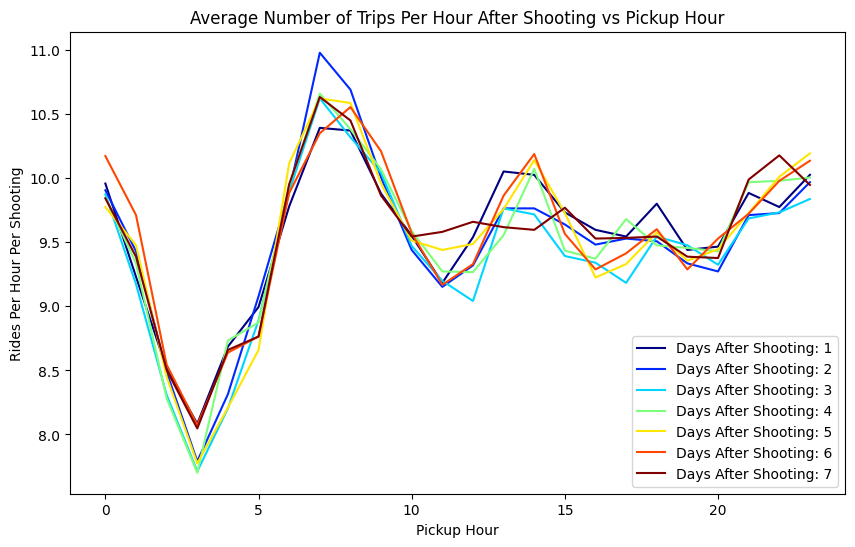

In [33]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = filtered_grouped_shooting_data.toPandas()

# Plotting using matplotlib
plt.figure(figsize=(10, 6))
days_after_shooting_values = pandas_df['days_after_shooting'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(days_after_shooting_values)))  # Generate colors

for idx, day in enumerate(days_after_shooting_values):
    day_df = pandas_df[pandas_df['days_after_shooting'] == day]
    plt.plot(day_df['pickup_hour'], day_df['RidesPerHour'], label=f'Days After Shooting: {day}', color=colors[idx])

plt.xlabel("Pickup Hour")
plt.ylabel("Rides Per Hour Per Shooting")
plt.title("Average Number of Trips Per Hour After Shooting vs Pickup Hour")
plt.legend()

# Save the plot as an image
plt.savefig("../plots/Daily_Avg_Trips_Post_Shooting.png")

plt.show()